In [24]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
%matplotlib inline
print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.2


In [25]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

# NBA foul analysis with Item Response Theory
Based on the Austin Rochford blog post [NBA Foul Calls and Bayesian Item Response Theory](https://www.austinrochford.com/posts/2017-04-04-nba-irt.html).

This tutorial shows an application of [Bayesian Item Response Theory](https://www.springer.com/us/book/9781441907417) to NBA basketball foul calls data using [PyMC3](https://pymc3.readthedocs.io/en/latest/index.html). The general scnario is that we observe a binary outcome (a foul being called or not) from an interaction (a basketball play) of two agents (the player committing the alleged foul and the player disadvantaged in the play). Moreover, some committing or disadvantaged agents are considered to be the same individual in multiple observations (say LeBron James observed committing a foul in more than one play). Now suppose we believe that not only the agent's role, but also the abilities of the single individual player contribute to the observed outcome. Then we'd like to estimate how much each individual's (latent) ability, along with the role as a committing or  disadvantaged agent, contributes to the observed outcome. 

This is a common but complex multi-agent interaction scenario, with hierarchical structures between committing/disadvantaged agents and individuals. However,  Bayesian Item Response Theory combined with modern powerful statistical software, allows for quite elegant modelling options. One of this options employs the [Rasch model](https://en.wikipedia.org/wiki/Rasch_model), which now discuss in detail.


Our data has been collected from the official [NBA Last Two Minutes Reports](https://official.nba.com/2020-21-nba-officiating-last-two-minute-reports/). Each row `k` of this dataset refers to a play involving two players (the committing and the disadvataged) where a foul has been either called or not. So we model the probability `p_k` that a foul was called in play `k` as a function of the players involved. So we can define two latent variables for each player, namely:
- `θ`: which estimates the player's ability of having a foul called when disadvantaged, and
- `b`: which estimates the player's  ability  of having a foul not called when committing.

These two parameters are then estimated using a standard Rasch model, by assuming the log-odds-ratio of `p_k` equals `θ-b` for the corresponding players involved in play `k`. Also, we place hierarchical hyperpriors on `θ` and `b` to acocunt for shared abilities between players and largely different number of observations for different players.

The analysis is divided in four sections: 

1. Data collection and processing, 
2. Construction of the Rasch model, 
3. HMC sampling and convergence checks and
4. Analysis of the posterior results.

# Data collection and processing
We first import the original data set, and restric ourself to only a selection of columns. (The original dataset can be found at [this url](https://raw.githubusercontent.com/polygraph-cool/last-two-minute-report/32f1c43dfa06c2e7652cc51ea65758007f2a1a01/output/all_games.csv).) We also plot the number of rows/plays where a correct or incorrect call or noncall was observed.

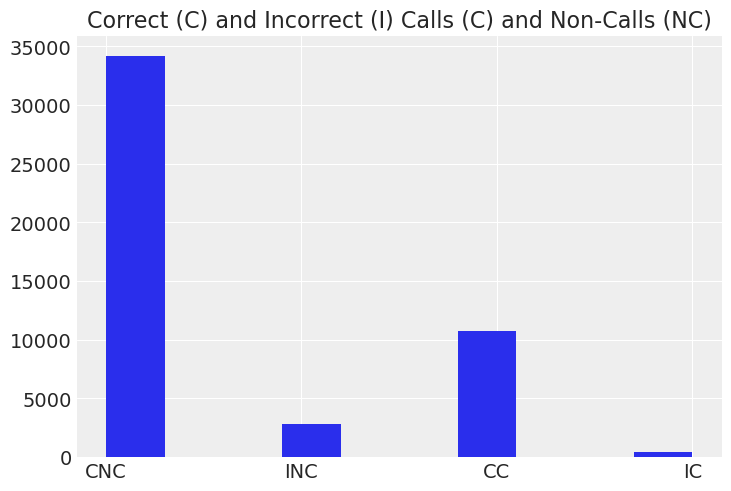

In [26]:
try:
    orig_df = pd.read_csv('./data/basketball_fouls.csv',low_memory=False)
except FileNotFoundError:
    orig_df = pd.read_csv(pm.get_data('basketball_fouls.csv'))
    
USECOLS = ['committing', 'disadvantaged', 'decision']
df = orig_df[USECOLS].dropna(axis=0)
df['decision'].hist()
plt.title('Correct (C) and Incorrect (I) Calls (C) and Non-Calls (NC)');

We now perform some manipulation of our data.
 1. We create a column called `foul_called` that assigns 1 to a play if a foul was called, and 0 otherwise.
 2. We remove plays where either the committing or the disadvantaged player is not available, which is often given by the team name rather than `None`.
 3. We assign a unique id to all disadvantaged and all committing players and we add two columns to `df`, `committing_player_id` and `disadvantaged_player_id`, which give the id of the committing and disadvantaged players involved in each play.

In [27]:
#1
def foul_called(decision):
    out = 0
    if (decision == 'CC') | (decision == 'IC'):
        out = 1
    return out
df = df.assign(foul_called=lambda df: df['decision'].apply(foul_called))

#2
def player_available(player):
    if (player != None) & (player != 'Nene'):
        if len(player.split(' '))==1:
            player = None
    return player
df = df.assign(committing=lambda df: df['committing'].apply(player_available))
df = df.assign(disadvantaged=lambda df: df['disadvantaged'].apply(player_available))
df = df[df.committing.notna()]
df = df[df.disadvantaged.notna()]

#3
disadvantaged = list(set(df.disadvantaged))
disadvantaged.sort()
committing = list(set(df.committing))
committing.sort()
def player_id_disadvantaged(player):
    return disadvantaged.index(player)
def player_id_committing(player):
    return committing.index(player)
df = df.assign(committing_player_id=lambda df: 
               df.committing.apply(player_id_committing))
df = df.assign(disadvantaged_player_id=lambda df: 
               df.disadvantaged.apply(player_id_disadvantaged))
df.index.name = 'play_id'
df.head()

,committing,disadvantaged,decision,foul_called,committing_player_id,disadvantaged_player_id
play_id,,,,,,
1,Avery Bradley,Stephen Curry,CNC,0,52,670
3,Isaiah Thomas,Andre Iguodala,CNC,0,297,28
4,Jae Crowder,Harrison Barnes,INC,0,314,263
6,Draymond Green,Isaiah Thomas,CC,1,214,281
7,Avery Bradley,Stephen Curry,CC,1,52,670


# Item Response (Rasch) Model

## Model definition and PyMC3 implementation

We denote by:
- $N_d$ and $N_c$ the number of disadvantaged and committing players, respcetively, 
- $K$ the number of plays,
- $k$ a play, 
- $y_k$ the observed call/not call in play $k$,
- $p_k$ the probability of a foul being called in play $k$,
- $i(k)$ the disadvantaged player in play $k$, and by
- $j(k)$ the committing player in play $k$.

We assume that each disadvantaged player is described by the latent variable: 
- $\theta_i$ for $i=1,2,...,N_d$,

and each committing player is described by the latent variable: 
- $b_j$ for $j=1,2,...,N_c$.

Then we model each observation $y_k$ as the result of an independent Bernoulli trial with probability $p_k$, where
$$
p_k =\text{sigmoid}(\eta_k)=\left(1+e^{-\eta_k}\right)^{-1},\quad\text{with}\quad \eta_k=\theta_{i(k)}-b_{j(k)},
$$
by defining 
\begin{align*}
\theta_{i}&= \sigma_\theta\Delta_{\theta,i}+\mu_\theta\sim \text{Normal}(\mu_\theta,\sigma_\theta^2),  &i=1,2,...,N_d,\\
b_{j}&= \sigma_b\Delta_{b,j}\sim \text{Normal}(0,\sigma_b^2), &j=1,2,...,N_c,
\end{align*}
with priors 
\begin{align*}
\Delta_{\theta,i}&\sim \text{Normal}(0,1),  &i=1,2,...,N_d,\\
\Delta_{b,j}&\sim \text{Normal}(0,1), &j=1,2,...,N_c,\\
\mu_\theta&\sim \text{Normal}(0,100),\\
\sigma_\theta &\sim \text{HalfCauchy}(2.5),\\
\sigma_b &\sim \text{HalfCauchy}(2.5).
\end{align*}

Note that $p_k$ is always dependent on $\mu_\theta,\,\sigma_\theta$ and $\sigma_b$ ("pooled priors") and also depends on the actual players involved in the play due to  $\Delta_{\theta,i}$ and $\Delta_{b,j}$ ("unpooled priors"). This means our model features partial pooling. Also note that  we normalised the mean of $b_{j}$ to zero.

We now implement the model above in PyMC3. Note that, too easily keep track of the players (as we have hundreds of them), we make use of the `coords` argument for `pm.Model` below. (For tutorials on this functionality, see [this blog post]() or  [this PyMC3 example](https://docs.pymc.io/notebooks/data_container.html).)

In [18]:
coords = {'disadvantaged': disadvantaged, 'committing': committing}

#observed_committing_id = df.committing_player_id
#observed_disadvantaged_id = df.disadvantaged_player_id
#observed_call = df.foul_called

#https://docs.pymc.io/notebooks/data_container.html 
#for data trick

with pm.Model(coords=coords) as model:
    #Data
    disadvantaged_observed = pm.Data('disadvantaged_observed', df.disadvantaged_player_id)
    committing_observed = pm.Data('committing_observed', df.committing_player_id)
    foul_called_observed = pm.Data('foul_called_observed', df.foul_called)
    
    #Prior
    μ_θ = pm.Normal('μ_θ',0.,100.)
    σ_θ = pm.HalfCauchy('σ_θ',2.5)
    Δ_θ = pm.Normal('Δ_θ', 0., 1., dims='disadvantaged')  
    σ_b = pm.HalfCauchy('σ_b',2.5)
    Δ_b = pm.Normal('Δ_b', 0., 1., dims='committing') 
    
    #Deterministic
    θ = pm.Deterministic('θ', Δ_θ*σ_θ+μ_θ, dims='disadvantaged')
    b = pm.Deterministic('b', Δ_b*σ_b, dims='committing')
    η = pm.Deterministic('η', θ[disadvantaged_observed]-b[committing_observed])
    p = pm.Deterministic('p', tt.nnet.sigmoid(η))
    
    #Likelihood
    y = pm.Bernoulli('y',  p, observed=foul_called_observed)

We use the method `model_to_graphviz` to plot our model. This shows the hierarchical structure on the variables `θ` and `b`.

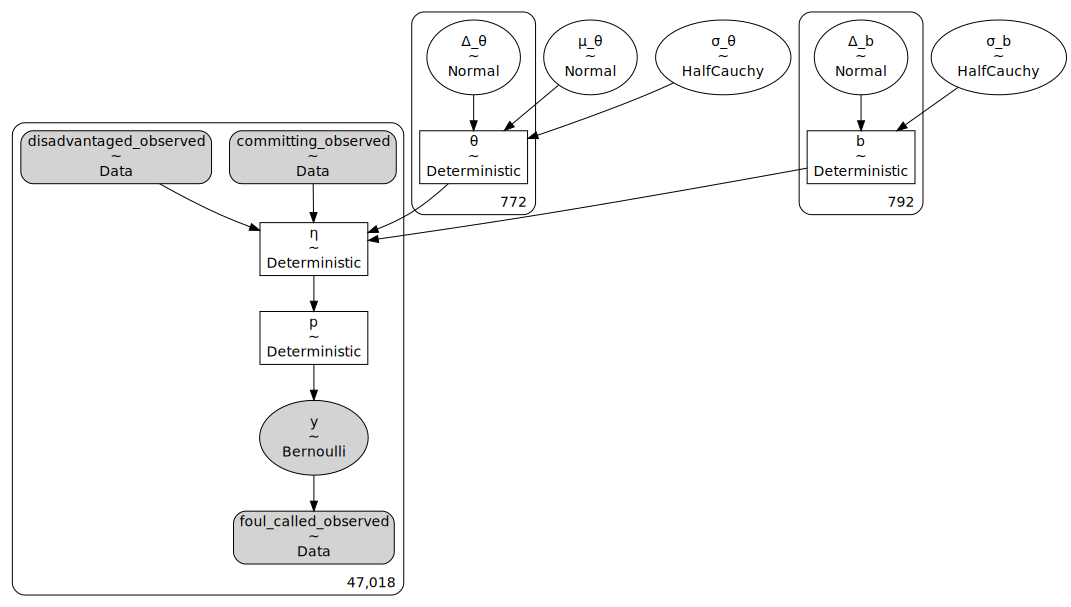

In [19]:
pm.model_to_graphviz(model)

## Model Sampling and convergence

We now sample from our Rasch model and then plot the energy difference of the obtained trace. 

In [ ]:
with model:
    trace = pm.sample(1000,
                      tune=1000,
                      return_inferencedata=True, 
                      random_seed=RANDOM_SEED)
pm.plot_energy(trace);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Δ_b, σ_b, Δ_θ, σ_θ, μ_θ]


We assume our sampler has converged as it passed all automatic PyMC3 convergence checks.

## Posterior analysis
We now plot our results using forest plots. We plot the top and bottom 10 players ranked with respect to `θ` and `b`, respectively. The black vertical dashed line is the posterior mean of `μ_θ` in the plots of `θ`, and the arbitrary 0 mean in the plots of `b`.

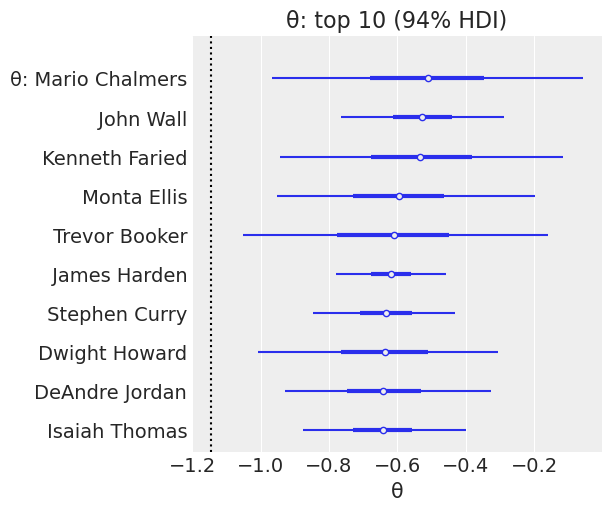

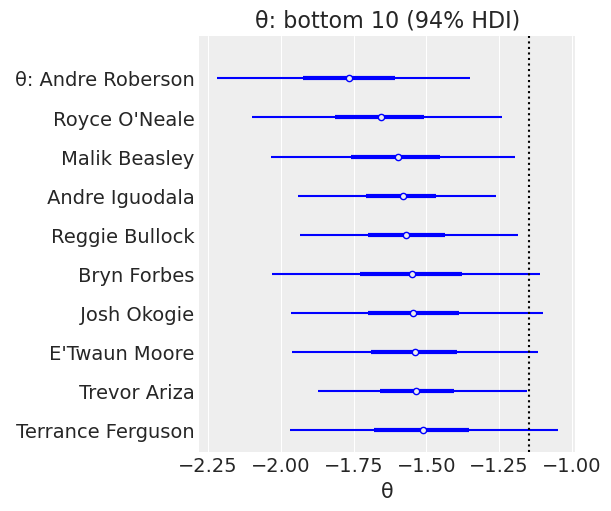

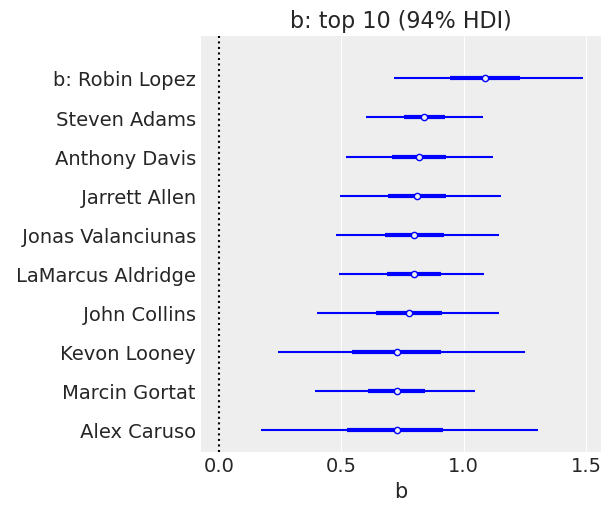

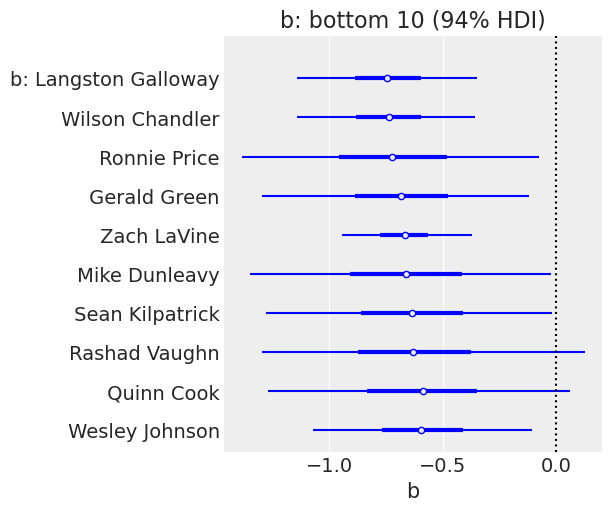

In [21]:
def top_bottom_10(inferencedata,var,bottom_bool):
    xarray_ = inferencedata.posterior[var].mean(dim=['chain','draw'])
    return xarray_.sortby(xarray_,ascending=bottom_bool)
xarr_top_theta = top_bottom_10(trace,'θ',False)
xarr_bottom_theta = top_bottom_10(trace,'θ',True)
xarr_top_b = top_bottom_10(trace,'b',False)
xarr_bottom_b = top_bottom_10(trace,'b',True)
μ_θ_mean, μ_b_mean = trace.posterior['μ_θ'].mean(), 0

ax= az.plot_forest(trace,var_names=['θ'], combined=True,
                   coords={'disadvantaged':xarr_top_theta[:10].coords['disadvantaged']})
ax[0].set_title('θ: top 10 (94% HDI)')
ax[0].set_xlabel('θ')
ax[0].axvline(μ_θ_mean,color='black',ls=':', label ='mean') 

ax= az.plot_forest(trace,var_names=['θ'],coords={'disadvantaged':xarr_bottom_theta[:10].coords['disadvantaged']},
              colors='blue', combined=True) 
ax[0].set_title('θ: bottom 10 (94% HDI)')
ax[0].set_xlabel('θ')
ax[0].axvline(μ_θ_mean,color='black',ls=':') 

ax= az.plot_forest(trace,var_names=['b'],coords={'committing':xarr_top_b[:10].coords['committing']},
              colors='blue', combined=True) 
ax[0].set_title('b: top 10 (94% HDI)')
ax[0].set_xlabel('b')
ax[0].axvline(μ_b_mean,color='black',ls=':') 

ax= az.plot_forest(trace,var_names=['b'],coords={'committing':xarr_bottom_b[:10].coords['committing']},
              colors='blue', combined=True) 
ax[0].set_title('b: bottom 10 (94% HDI)')
ax[0].set_xlabel('b')
ax[0].axvline(μ_b_mean,color='black',ls=':');

In [ ]:
'''#print(len(df.loc[df.committing == xarr_top_theta[:10].coords['players'][0]]),len(df.loc[df.committing == xarr_top_theta[:10].coords['players'][5]]),len(df.loc[df.committing == xarr_top_theta[:10].coords['players'][6]]))
print(df.loc[df.committing == xarr_top_theta[:10].coords['players'][0]].foul_called.mean())
print(1/(1+np.exp(-(xarr_top_theta[0]))))
#xarr_top_theta[0]
'''
no_commit = []
both = set(df.committing).intersection(set(df.disadvantaged))
for x in set(df.disadvantaged):
    if x not in both:
        no_commit.append(x)
df.loc[df.disadvantaged == 'Bryce Cotton']
ax=az.plot_forest(trace,var_names=['b'],coords={'disadvantaged':['Bryce Cotton']})

In [ ]:
df.loc[df.committing == no_commit[0]]
ax=az.plot_forest(trace,var_names=['θ'],coords={'players':no_commit})
ax[0].axvline(μ_θ_mean,color='black',ls=':', label ='mean') 

In [ ]:
coords_to_plot = {'players': ['Eric Gordon','LeBron James','Russell Westbrook','James Harden','Marco Belinelli','Dwight Howard']}

#pm.plot_forest(1/(1+np.exp(-(trace.posterior['θ'][:,:,:5]) )))
#pm.plot_forest(trace.posterior['p'][:,:,:5]) 
ax = az.plot_forest(trace,var_names=['θ'],coords=coords_to_plot,
                   colors='blue', combined=True, ) 
ax[0].set_title('Players skill θ, 94% HDI')
ax[0].set_xlabel('θ')
ax[0].axvline(mu_θ_mean,color='black',ls=':') 

ax = az.plot_forest(trace,var_names=['b'],coords=coords_to_plot,
                   
                   colors='blue', combined=True) #figsize=(9, 7),kind='ridgeplot', ridgeplot_quantiles=[.06, .5, .95],
ax[0].set_title('Players difficulty $b_k$')
ax[0].set_xlabel('b')
ax[0].axvline(mu_b_mean,color='black',ls=':') 
#https://arviz-devs.github.io/arviz/api/generated/arviz.plot_forest.html

Interesting to see that Russell Westbrook ability is higher than the mean, meanwhile difficoulty is loer than the mean. collect all of those? 

In [23]:
%load_ext watermark
%watermark -n -u -v -iv -w -p xarray

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Thu Jun 10 2021

Python implementation: CPython
Python version       : 3.9.4
IPython version      : 7.24.1

xarray: 0.18.2

arviz     : 0.11.2
theano    : 1.0.5
matplotlib: 3.4.2
pandas    : 1.2.4
numpy     : 1.20.3
pymc3     : 3.11.2

Watermark: 2.2.0

